In [4]:
using PorousMaterials # Pkg.clone("https://github.com/SimonEnsemble/PorousMaterials.jl", "v0.1.1")
using CSV
using DataFrames
using TSne
using PyCall
@pyimport adjustText
import PyPlot; const plt = PyPlot # now do plt.plt[:hist] for example
using DelimitedFiles
using LinearAlgebra
using Printf
using Random
using Optim
using ProgressMeter
using JLD2
using CoherentPointDrift # https://github.com/SimonEnsemble/CoherentPointDrift.jl

Cage database CDB41 (41 cages) from [here](https://github.com/marcinmiklitz/CDB41). Cleaned of solvent. Thanks to Kim Jelfs and M. Miklitz for kindly providing the cages.

Reference:
> M. Miklitz, S. Jiang, R. Clowes, M. E. Briggs, A. I. Cooper and K. E. Jelfs, Computational Screening of Porous Organic Molecules for Xenon/Krypton Separation, J. Phys. Chem. C, 2017. DOI: 10.1021/acs.jpcc.7b03848

Other set of 33 cages from the .xyz files deposited as ESI of DOI 10.1038/s41467-018-05271-9

> R. L. Greenaway, V. Santolini, M. J. Bennison, B. M. Alston, C. J. Pugh, M. A. Little, M. Miklitz, E. G. B. Eden-Rump, R. Clowes, A. Shakil, H. J. Cuthbertson, H. Armstrong, M. E. Briggs, K. E. Jelfs & A. I. Cooper. High-throughput discovery of organic cages and catenanes using computational screening fused with robotic synthesis. Nature Communications, 2018. DOI: 10.1038/s41467-018-05271-9
                                                              
I manually looked at Fig 4 in the main text and selected those that were synthesized. Some cages required visualization to compare to Fig 4 since e.g. there are multiple versions of B23, a few of which were apparently not synthesized but only computational predictions.

The `.xyz` files describing the molecular structure of all of these cages are in the directory `all_cages`.

In [5]:
cages = readdlm("all_cages/all_cages.txt")
cages[1]

"A11"

In [6]:
aligned_and_centered_cage(cage::AbstractString) = read_xyz("all_cages/" * cage * "_final_alignment.xyz")
final_aligned_and_centered_cage(cage::AbstractString) = read_xyz("final_aligned_cages/" * cage * ".xyz")

final_aligned_and_centered_cage (generic function with 1 method)

## Generate 3D void space images
Superimpose a regular 3D grid of points centered at the cage center of mass. 
Compute the potential energy of a Helium probe at each grid point.
If the energy is less than a certain value, that point is declared "accessible".
Think of this as a CAT scan for cages!

Set up computation of potential energy of Helium probe in the cages

In [7]:
he = Molecule("He")

cutoffradius = 14.0 # vdw cutoff radius
ljff = LJForceField("UFF.csv", cutoffradius=cutoffradius, mixing_rules="geometric");

Write padded .cif files of the cages for molecular simulations. 
In the same loop, determine what size of snapshot we need to encapsulate all cages.

In [8]:
snapshot_dim = 0.0 # find max dimension we need for snapshot to include all atoms of all cages
biggest_cage = ""

for cage in cages
    # read in aligned and centered cage
    atoms, x = final_aligned_and_centered_cage(cage)
    # observe max dimension so we know size of snapshot to take.
    x_span = 2.0 * maximum(abs.(x))
    if x_span > snapshot_dim # 2 b/c centered at zero
        snapshot_dim = x_span
        biggest_cage = cage
    end
    
    #
    # write to .cif for molecular simulation
    #
    # make sure with PBCs no interactions are included by padding
    box = Box([x_span + 2 * cutoffradius for blah = 1:3]..., 
              [π/2 for blah = 1:3]...)
    # when writing .cif, shift coords so they are in [0, 1]^3
    #    so in .cif center of mass is center of box.
    x_shift = [x_span + 2 * cutoffradius for blah = 1:3] / 2.0
    framework = Framework(cage, box, 
                          Atoms(atoms, x), 
                          Charges(Array{Float64, 1}(undef, 0), Array{Float64, 2}(undef, 0, 0))
                          )
    write_cif(framework, 
        @sprintf("data/crystals/%s_aligned.cif", cage))
end

println("aligned and centered cages written to .xyz in all_cages/*_aligned.xyz")
println("see data/crystals for .cif's padded by cutoffradius for molecular simulations'")
println("Largest cage: :", biggest_cage)

aligned and centered cages written to .xyz in all_cages/*_aligned.xyz
see data/crystals for .cif's padded by cutoffradius for molecular simulations'
Largest cage: :MC6


In [9]:
snapshot_dim = ceil(snapshot_dim)
println("Dimension of snapshot to fit all porous cages (Å): ", snapshot_dim)

const center_of_box = [snapshot_dim / 2.0 for d = 1:3]

const snapshot_box = Box(snapshot_dim, snapshot_dim, snapshot_dim, π/2, π/2, π/2)

Dimension of snapshot to fit all porous cages (Å): 39.0


Bravais unit cell of a crystal.
	Unit cell angles α = 90.000000 deg. β = 90.000000 deg. γ = 90.000000 deg.
	Unit cell dimensions a = 39.000000 Å. b = 39.000000 Å, c = 39.000000 Å
	Volume of unit cell: 59319.000000 Å³


Discretize space; `x_grid_pts` ranges from `-snapshot_dim` to `snapshot_dim` so it overlays the cage coordinates.

In [10]:
const nb_grid_pts = 25
const x_grid_pts = collect(range(0, stop=snapshot_dim, length=nb_grid_pts)) .- snapshot_dim / 2.0

25-element Array{Float64,1}:
 -19.5  
 -17.875
 -16.25 
 -14.625
 -13.0  
 -11.375
  -9.75 
  -8.125
  -6.5  
  -4.875
  -3.25 
  -1.625
   0.0  
   1.625
   3.25 
   4.875
   6.5  
   8.125
   9.75 
  11.375
  13.0  
  14.625
  16.25 
  17.875
  19.5  

Build data matrix `A`, whose rows are the flattened snapshots of a particular cage.

In [11]:
A = zeros(Float64, length(cages), nb_grid_pts ^ 3)

for (c, cage) in enumerate(cages)
    # read in aligned and centered cage
    atoms, x = final_aligned_and_centered_cage(cage)
    
    # assert snapshot box is big enough
    @assert(all(x .< maximum(x_grid_pts)) && all(x .> minimum(x_grid_pts)),
        "atoms outside snapshot!")
    
    # convert cage to a list of LJSphere's for PorousMaterials.jl
    ljspheres = Atoms(atoms, x)
    
    # preallocate grid; choose origin here solely for visualization
    # when we write to a .cube file. the origin passed to `Grid`
    # is so the cage is centered at the origin in the viz. (checked)
    grid = Grid(snapshot_box, (nb_grid_pts, nb_grid_pts, nb_grid_pts), 
                zeros(Float64, nb_grid_pts, nb_grid_pts, nb_grid_pts), 
                :accessibility, -center_of_box)
        
    for i = 1:nb_grid_pts, j = 1:nb_grid_pts, k = 1:nb_grid_pts
        # what grid pt is here inside the loop?
        x_grid_pt = [x_grid_pts[i], x_grid_pts[j], x_grid_pts[k]]
        
        # put helium at this grid pt
        translate_to!(he, x_grid_pt)
        
        # compute potential energy of He adsorbate here
        energy = vdw_energy_no_PBC(he, ljspheres, ljff)
        
        # if framework atom overlaps with cage atom... energy > k T
        if energy > 298.0
            grid.data[i, j, k] = 1.0
        end
    end
    
    # save grid for visualization
    write_cube(grid, cages[c] * ".cube", verbose=false)
    
    # add flattened grid as a row of the matrix `A`
    A[c, :] = grid.data[:]
    
    # assert that we can recover the snapshot by reshaping the rows of A
    @assert(isapprox(
            reshape(A[c, :], (nb_grid_pts, nb_grid_pts, nb_grid_pts)),
            grid.data)
           )
end

println("see data/grids for .cube visualizations of the cage scans")
size(A)

see data/grids for .cube visualizations of the cage scans


(74, 15625)

Look at rank of $A$. Do any two cages have the same representation?

In [12]:
println("rank of A: ", rank(A))
for i = 1:length(cages)
    for j = (i+1):length(cages)
        if norm(A[i, :] - A[j, :]) < 5.0
            @printf("Cages %s and %s hv same raw representation!\n", cages[i], cages[j])
        end
    end
    # just in case...
    if all(A[i, :] .== 0.0) || all(A[i, :] == 1.0)
        println("Cage is all zeros or all ones! ", cages[i])
    end
end

rank of A: 74


Compute the average cage.

In [13]:
average_cage = zeros(Float64, nb_grid_pts ^ 3)
for c = 1:length(cages)
    average_cage += A[c, :]
end
average_cage /= length(cages)

# write to .cube
grid = Grid(snapshot_box, (nb_grid_pts, nb_grid_pts, nb_grid_pts), 
            reshape(average_cage, (nb_grid_pts, nb_grid_pts, nb_grid_pts)), 
            :accessibility, -center_of_box)

write_cube(grid, "average_cage.cube")
@printf("%d/%d pixels nonzero in average cage\n", sum(average_cage .!= 0), length(average_cage))

	See /home/sturlusa/my_projects/latent_cage_space/data/grids/average_cage.cube
5142/15625 pixels nonzero in average cage


Subtract off the average cage from each cage.

In [14]:
for c = 1:length(cages)
    A[c, :] = A[c, :] - average_cage
end

At this point, if $\mathbf{x_i}$ is a feature vector (a row of `A`), then $\sum_i \mathbf{x_i} = \mathbf{0}$. See [here](https://epubs.siam.org/doi/pdf/10.1137/S0036144501387517).

In [15]:
x_sum = zeros(nb_grid_pts ^ 3)
for c = 1:length(cages)
    x_sum += A[c, :]
end
@assert(all(isapprox.(x_sum, zeros(nb_grid_pts ^ 3), atol=1e-5)))

Visualize the matrix (half of a joke)

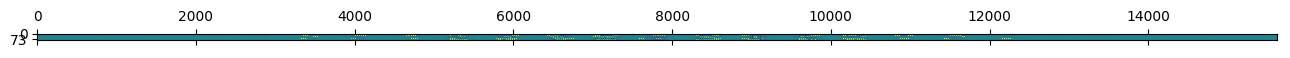

In [16]:
plt.matshow(A)
plt.yticks([0, length(cages)-1])
plt.tight_layout()
plt.savefig("data_matrix_viz.png", format="png", dpi=300, bbox_inches="tight")

How many columns are all zeros?

In [17]:
sum(sum(abs.(A), dims=1) .== 0.0)

10483

In [18]:
rank(A)

73

Perform the SVD decomposition of the data matrix

In [19]:
UΣVᵀ = svd(A)

println("size of U: ", size(UΣVᵀ.U))
println("# singular values: ", length(UΣVᵀ.S))
println("size of Vᵀ: ", size(UΣVᵀ.Vt))

@assert(isapprox(A, UΣVᵀ.U * diagm(0 => UΣVᵀ.S) * UΣVᵀ.Vt))

size of U: (74, 74)
# singular values: 74
size of Vᵀ: (74, 15625)


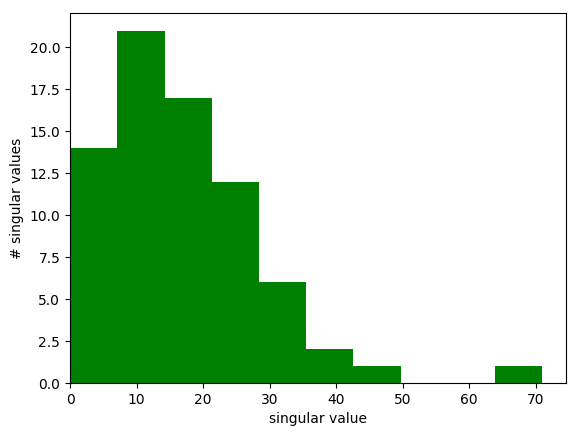

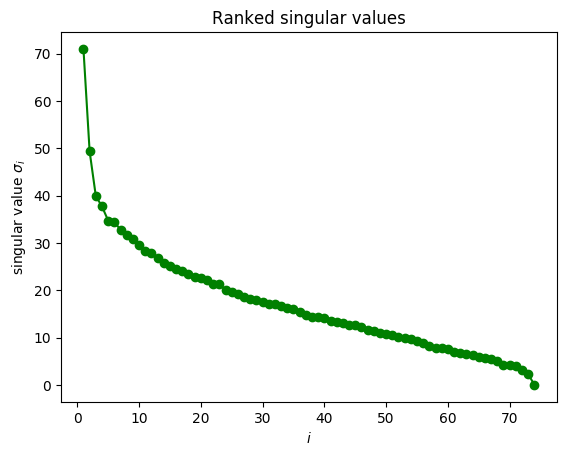

In [20]:
plt.figure()
plt.plt[:hist](UΣVᵀ.S, color="g")
plt.xlabel("singular value")
plt.ylabel("# singular values")
plt.xlim(xmin=0)
plt.savefig("distn_of_svs.png", format="png", dpi=300)

plt.figure()
plt.plot(1:length(UΣVᵀ.S), UΣVᵀ.S, color="g", marker="o")
plt.xlabel("\$i\$")
plt.ylabel("singular value \$\\sigma_i\$")
plt.title("Ranked singular values")
plt.savefig("svs_ordered.png", format="png", dpi=300)

ratio of norm of error to norm of $A$.
See pg. 19 of 
> A Singularly Valuable Decomposition: The SVD of a Matrix. Dan Kalman

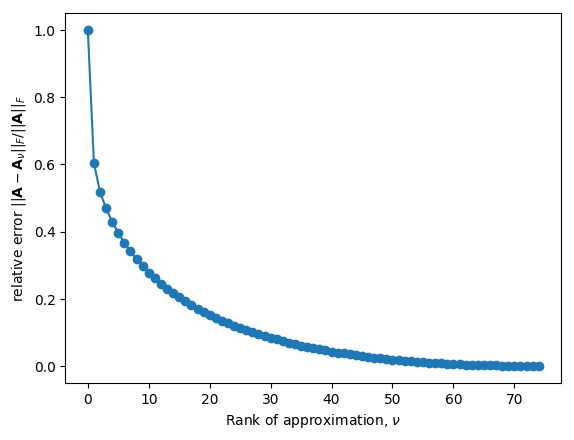

In [21]:
relative_err = 1.0 .- sqrt.([sum(UΣVᵀ.S[1:i] .^ 2) for i = 1:length(UΣVᵀ.S)] / sum(UΣVᵀ.S .^ 2))
relative_err = vcat([1.0], relative_err)

fig = plt.figure()
plt.xlabel("Rank of approximation, \$\\nu\$")
plt.ylabel("relative error \$||\\mathbf{A}-\\mathbf{A}_\\nu||_F/||\\mathbf{A}||_F \$")
plt.plot(0:length(UΣVᵀ.S), relative_err, marker="o")
plt.savefig("relative_err_with_svs.png", format="png", dpi=300)

Take the latent space as a composition of the first `r` singular vectors.
Select `r` so that we recover a certain fraction of the energy, `fraction_energy_recovered`.

In [22]:
# assert singular values are sorted
@assert(sortperm(UΣVᵀ.S) == reverse([i for i = 1:length(UΣVᵀ.S)]))

desired_relative_err = 0.15
ν = findfirst(relative_err .< desired_relative_err) # number of singular values to include

printstyled(@sprintf("%d singular values results in relative error %f; setting latent dim = %d.\n",
    ν, relative_err[ν], ν), color=:red)

x_latent = UΣVᵀ.U[:, 1:ν] * diagm(0 => UΣVᵀ.S[1:ν])
@assert(isapprox(x_latent, A * UΣVᵀ.V[:, 1:ν]), "UΣ != AV")
@assert(size(x_latent) == (length(cages), ν))

22 singular values results in relative error 0.142810; setting latent dim = 22.


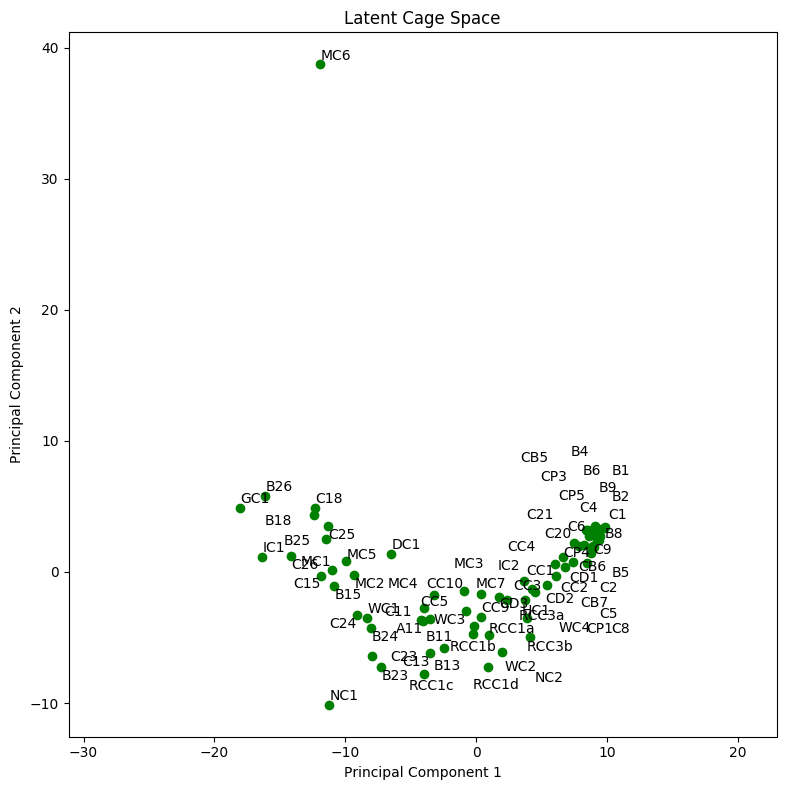

In [23]:
x_pca = UΣVᵀ.U[:,1:2] * diagm(0 => UΣVᵀ.S[1:2])

fig = plt.figure(figsize=(8,8))
plt.scatter(x_pca[:, 1], x_pca[:, 2], color="g")

texts = []
for i = 1:length(cages)
    push!(texts,
        plt.annotate(cages[i], (x_pca[i, 1], x_pca[i, 2]))
    )
end
adjustText.adjust_text(texts)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.axis("equal")
plt.title("Latent Cage Space")
plt.tight_layout()
plt.savefig("PCA_latent_cage_space_2D.pdf", format="pdf", dpi=300)
plt.show()

Lets see where the flexible CC2, CC3 and CC4 cages get mapped to in this latent space

In [36]:
flexible_cages_cc2 = readdlm("all_cages/flexible_cages/flexible_cc2_files.txt")
flexible_cages_cc3 = readdlm("all_cages/flexible_cages/flexible_cc3_files.txt")
flexible_cages_cc4 = readdlm("all_cages/flexible_cages/flexible_cc4_files.txt")
flexible_cages_cc5 = readdlm("all_cages/flexible_cages/flexible_cc5_files.txt")
flexible_cages = [flexible_cages_cc2..., flexible_cages_cc3..., flexible_cages_cc4..., flexible_cages_cc5...]

1600-element Array{SubString{String},1}:
 "all_cages/flexible_cages/CC2_xyz/cc2_100.xyz"
 "all_cages/flexible_cages/CC2_xyz/cc2_101.xyz"
 "all_cages/flexible_cages/CC2_xyz/cc2_102.xyz"
 "all_cages/flexible_cages/CC2_xyz/cc2_103.xyz"
 "all_cages/flexible_cages/CC2_xyz/cc2_104.xyz"
 "all_cages/flexible_cages/CC2_xyz/cc2_105.xyz"
 "all_cages/flexible_cages/CC2_xyz/cc2_106.xyz"
 "all_cages/flexible_cages/CC2_xyz/cc2_107.xyz"
 "all_cages/flexible_cages/CC2_xyz/cc2_108.xyz"
 "all_cages/flexible_cages/CC2_xyz/cc2_109.xyz"
 "all_cages/flexible_cages/CC2_xyz/cc2_10.xyz" 
 "all_cages/flexible_cages/CC2_xyz/cc2_110.xyz"
 "all_cages/flexible_cages/CC2_xyz/cc2_111.xyz"
 ⋮                                             
 "all_cages/flexible_cages/CC5_xyz/cc5_8.xyz"  
 "all_cages/flexible_cages/CC5_xyz/cc5_90.xyz" 
 "all_cages/flexible_cages/CC5_xyz/cc5_91.xyz" 
 "all_cages/flexible_cages/CC5_xyz/cc5_92.xyz" 
 "all_cages/flexible_cages/CC5_xyz/cc5_93.xyz" 
 "all_cages/flexible_cages/CC5_xyz/cc5_94.xyz" 

In [37]:
A_flexible = zeros(Float64, length(flexible_cages), nb_grid_pts ^ 3)

for (c, cage) in enumerate(flexible_cages)
    # read in aligned and centered cage
    atoms, x = read_xyz(cage)
    
    # assert snapshot box is big enough
    @assert(all(x .< maximum(x_grid_pts)) && all(x .> minimum(x_grid_pts)),
        "atoms outside snapshot!")
    
    # convert cage to a list of LJSphere's for PorousMaterials.jl
    ljspheres = Atoms(atoms, x)
    
    # preallocate grid; choose origin here solely for visualization
    # when we write to a .cube file. the origin passed to `Grid`
    # is so the cage is centered at the origin in the viz. (checked)
    grid = Grid(snapshot_box, (nb_grid_pts, nb_grid_pts, nb_grid_pts), 
                zeros(Float64, nb_grid_pts, nb_grid_pts, nb_grid_pts), 
                :accessibility, -center_of_box)
        
    for i = 1:nb_grid_pts, j = 1:nb_grid_pts, k = 1:nb_grid_pts
        # what grid pt is here inside the loop?
        x_grid_pt = [x_grid_pts[i], x_grid_pts[j], x_grid_pts[k]]
        
        # put helium at this grid pt
        translate_to!(he, x_grid_pt)
        
        # compute potential energy of He adsorbate here
        energy = vdw_energy_no_PBC(he, ljspheres, ljff)
        
        # if framework atom overlaps with cage atom... energy > k T
        if energy > 298.0
            grid.data[i, j, k] = 1.0
        end
    end
    
    # save grid for visualization
    # write_cube(grid, cages[c] * ".cube", verbose=false)
    
    # add flattened grid as a row of the matrix `A`
    A_flexible[c, :] = grid.data[:]
    
    # assert that we can recover the snapshot by reshaping the rows of A
    @assert(isapprox(
            reshape(A_flexible[c, :], (nb_grid_pts, nb_grid_pts, nb_grid_pts)),
            grid.data)
           )
end

size(A)

(74, 15625)

In [38]:
for c = 1:length(flexible_cages)
    A_flexible[c, :] = A_flexible[c, :] - average_cage
end

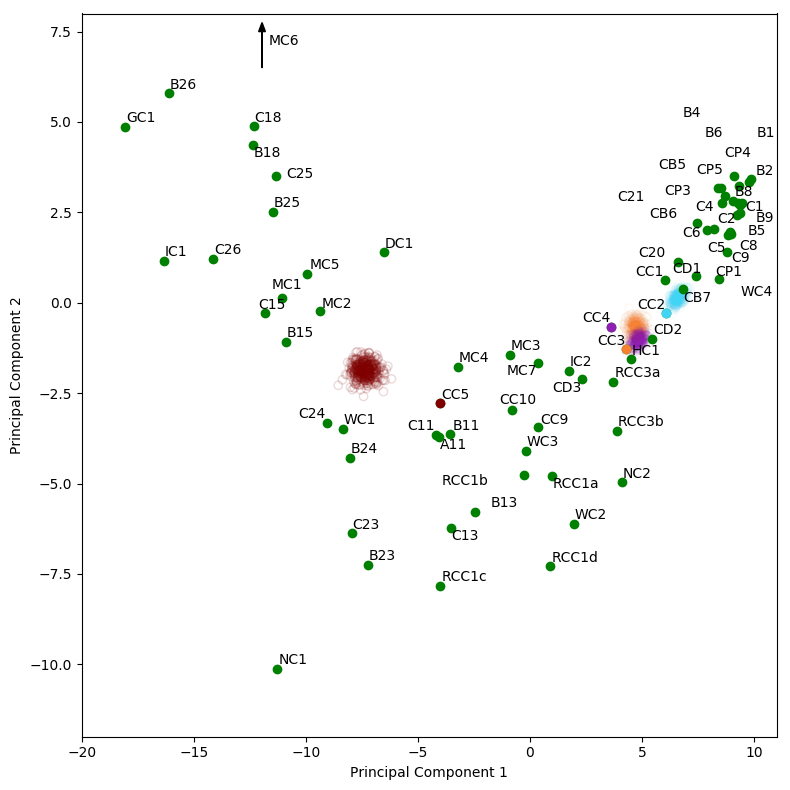

In [44]:
#x_pca = UΣVᵀ.U[:,1:2] * diagm(0 => UΣVᵀ.S[1:2])
flexible_x_pca = A_flexible * UΣVᵀ.V[:,1:2]
idx_mc6 = findfirst(cages .== "MC6")
idx_cc2 = findfirst(cages .== "CC2")
idx_cc3 = findfirst(cages .== "CC3")
idx_cc4 = findfirst(cages .== "CC4")
idx_cc5 = findfirst(cages .== "CC5")

fig = plt.figure(figsize=(8,8))
plt.scatter(flexible_x_pca[1:400,1], flexible_x_pca[1:400,2], color="#42d4f4", facecolor="none", alpha=0.05) #Cyan
plt.scatter(flexible_x_pca[401:800, 1], flexible_x_pca[401:800, 2], color="#f58231", facecolor="none", alpha=0.05) #Orange
plt.scatter(flexible_x_pca[801:1200, 1], flexible_x_pca[801:1200, 2], color="#911eb4", facecolor="none", alpha=0.05) #Purple
plt.scatter(flexible_x_pca[1201:1600, 1], flexible_x_pca[1201:1600, 2], color="#800000", facecolor="none", alpha=0.15) #Maroon
plt.scatter(x_pca[:, 1], x_pca[:, 2], color="g")
plt.scatter(x_pca[idx_cc2[1], 1], x_pca[idx_cc2[1], 2], color="#42d4f4")
plt.scatter(x_pca[idx_cc3[1], 1], x_pca[idx_cc3[1], 2], color="#f58231")
plt.scatter(x_pca[idx_cc4[1], 1], x_pca[idx_cc4[1], 2], color="#911eb4")
plt.scatter(x_pca[idx_cc5[1], 1], x_pca[idx_cc5[1], 2], color="#800000")

texts = []
for i = 1:length(cages)
    if cages[i] == "MC6"
        push!(texts,
            plt.annotate(cages[i], (x_pca[i, 1]+0.25, 7.0))
        )
    else
        push!(texts,
            plt.annotate(cages[i], (x_pca[i, 1], x_pca[i, 2]))
        )
    end
end
ymax = 8
plt.arrow(x_pca[idx_mc6[1], 1], ymax-1.5, 0, 1, head_width=0.3, head_length=0.25, fc="k", ec="k")
plt.xlim(-20, 11)
plt.ylim(-12, ymax)
adjustText.adjust_text(texts)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
#plt.axis("equal")
#plt.title("Main 2 PC Space")
plt.tight_layout()
plt.savefig("PCA_latent_cage_space_with_flexible_cages_2D.pdf", format="pdf", dpi=300)
plt.show()

use t-SNE to embed latent representation in 2D

In [ ]:
Random.seed!(1234)
x_tsne = tsne(x_latent, 2, 0, 100000, 5.0);
size(x_tsne)

write 2D t-SNE latent dim to file for D3 interactive viz

In [ ]:
latent_dim_file = open("latent_dim.csv", "w")
@printf(latent_dim_file, "cage_image,x1,x2\n")
for (c, cage) in enumerate(cages)
    @printf(latent_dim_file, "%s_aligned.png,%f,%f\n", cage, x_tsne[c, :]...)
end
close(latent_dim_file)

In [ ]:
plt.figure(figsize=(7, 7))
plt.scatter(x_tsne[:, 1], x_tsne[:, 2], color="g")
# for i = 1:length(cages)
#     plt.annotate(cages[i], (x_tsne[i, 1], x_tsne[i, 2]))
# end
texts = []
for i = 1:length(cages)
    push!(texts,
        plt.annotate(cages[i], (x_tsne[i, 1], x_tsne[i, 2]))
        )
end
adjustText.adjust_text(texts)
plt.xlabel("latent dim. 1")
plt.ylabel("latent dim. 2")
plt.axis("equal")
plt.title("latent cage space")
plt.tight_layout()
plt.savefig("latent_cage_space_2D.pdf", format="pdf", dpi=300)
plt.show()

... t-SNE to embed in 3D

In [ ]:
x_tsne_3D = tsne(x_latent, 3, 0, 10000, 5.0);

figure()
scatter3D(x_tsne_3D[:, 1], x_tsne_3D[:, 2], x_tsne_3D[:, 3])
show()

## Correlation between latent space and cage descriptors from `pywindow`

Crude cage size descriptors:

* `molecule_diameter`: if we could stuff the cage molecule into a sphere, how big would the sphere need to be?
* `void_diameter`: distance between center of mass of the molecule and the closest atom, corrected for appropriate vdW radii and multiplied by 2.

See:

> M. Miklitz, S. Jiang, R. Clowes, M. E. Briggs, A. I. Cooper and K. E. Jelfs, Computational Screening of Porous Organic Molecules for Xenon/Krypton Separation, J. Phys. Chem. C, 2017, 121, 15211–15222.

We computed these from `pywindow`:

> M. Miklitz, K. E. Jelfs. pywindow: Automated Structural Analysis of Molecular Pores. ChemRxiv.

(checked WC3 in Table 1 for correspondence of those we computed.) See `cage_descriptors.ipynb`.

In [ ]:
df_descriptors = CSV.read("pywindow_cage_descriptors.csv")
head(df_descriptors)

Put in an array with same order as `cages` for easy plotting

In [ ]:
pore_diameters = zeros(length(cages))
molecule_diameters = zeros(length(cages))
nb_windows = zeros(Int, length(cages))
for (i, cage) in enumerate(cages)
    idx_this_cage = df_descriptors[:cage] .== cage
    @assert(sum(idx_this_cage) == 1, @sprintf("%s not found in df_descriptors (or multiple)!", cage))
    pore_diameters[i] = df_descriptors[idx_this_cage, :pore_diameter_A][1]
    molecule_diameters[i] = df_descriptors[idx_this_cage, :molecule_diameter_A][1]
    nb_windows[i] = df_descriptors[idx_this_cage, :nb_windows][1]
end

Visualize distribution of descriptors among the cages.

In [ ]:
figure()
plt[:hist](pore_diameters, color="b", alpha=0.2, label="cavity")
plt[:hist](molecule_diameters, color="r", alpha=0.2, label="molecule")
legend()
xlabel("diameter (Å)")
ylabel("# cages")
savefig("pywindow_descriptors_distn.png", format="png", dpi=300)

Visualize distribution of the number of windows

In [ ]:
fig = figure()
plt[:hist](nb_windows, bins=0:10)
xlabel("# of windows into cavity")
ylabel("# of cages")

Assess if clustering picks on up the descriptors.
Color according to pore diameters, make size according to molecule diameter.
the marker size is the area, so we should make the size on the order of `molecule_diameter^2`.

In [ ]:
figure(figsize=(8, 7))
scatter(x_tsne[:, 1], x_tsne[:, 2],
    c=pore_diameters,
    s=molecule_diameters .^ 2 / maximum(molecule_diameters .^ 2) * 35.0,
    vmax=15.0
)
texts = []
for i = 1:length(cages)
    push!(texts,
        annotate(cages[i], (x_tsne[i, 1], x_tsne[i, 2]))
        )
end
adjustText.adjust_text(texts)
# for i = 1:length(cages)
#     plt.annotate(cages[i], (x_tsne[i, 1], x_tsne[i, 2]))
# end
cbar = colorbar(extend="max", label="cavity diameter (Å)")
title("latent cage space")
xlabel("latent dim. 1")
ylabel("latent dim. 2")
axis("equal")
tight_layout()
savefig("cage_space_colored_by_diams_2D.png", format="png", dpi=300)
show()

hypothesis that first eigencage picks up the pore size.

In [ ]:
fig = figure()
scatter(pore_diameters, UΣVᵀ.U[:, 1] * UΣVᵀ.S[1], color="C1")
xlabel("cavity diameter (Å)")
ylabel("first component of latent representation")
savefig("first_component_captures_pore_diameter.pdf", format="pdf")

Assess if clustering picks up on # windows 

In [ ]:
cmap = get_cmap("Pastel1", maximum(nb_windows) - minimum(nb_windows)+1)

figure(figsize=(8, 7))
scatter(x_tsne[:, 1], x_tsne[:, 2],
    c=nb_windows, cmap=cmap, vmin=minimum(nb_windows)-0.5, vmax=maximum(nb_windows)+0.5
)
texts = []
for i = 1:length(cages)
    push!(texts,
        annotate(cages[i], (x_tsne[i, 1], x_tsne[i, 2]))
        )
end
adjustText.adjust_text(texts)
# for i = 1:length(cages)
#     plt.annotate(cages[i], (x_tsne[i, 1], x_tsne[i, 2]))
# end
#cbar = plt.colorbar(extend="max", label="cavity diameter (Å)")
title("latent cage space")
xlabel("latent dim. 1")
ylabel("latent dim. 2")
axis("equal")
colorbar(label="# of windows to cavity")
tight_layout()
savefig("cage_space_colored_by_nb_windows.png", format="png", dpi=300)
show()

In [ ]:
fig = figure(figsize=(8, 7))
ax = fig[:add_subplot](111, projection="3d")

ax[:scatter](x_tsne_3D[:, 1], x_tsne_3D[:, 2], x_tsne_3D[:, 3],
    c=pore_diameters,
    s=molecule_diameters .^ 2 / maximum(molecule_diameters .^ 2) * 35.0,
    vmax=15.0)
for i = 1:length(cages)
    ax[:text](x_tsne_3D[i, 1], x_tsne_3D[i, 2], x_tsne_3D[i, 3], cages[i])
end
xlabel("latent dim. 1")
ylabel("latent dim. 2")
zlabel("latent dim. 3")
title("latent cage space")
tight_layout()
savefig("cage_space_colored_by_diams_3D.png", format="png", dpi=300)
show()

### Visualize the eigen-cages
i.e. discovered concepts, which are the rows of $\mathbf{V}^T$.

In [ ]:
for concept_id = 1:ν
    x_concept = transpose(UΣVᵀ.V)[concept_id, :] # flattened
    x_concept = reshape(x_concept, (nb_grid_pts, nb_grid_pts, nb_grid_pts))

    grid = Grid(snapshot_box, (nb_grid_pts, nb_grid_pts, nb_grid_pts), 
                reshape(x_concept, (nb_grid_pts, nb_grid_pts, nb_grid_pts)), 
                :accessibility, -center_of_box)

    write_cube(grid, @sprintf("eigencage%d.cube", concept_id))
end

### reconstruct a material as singular values are added

In [ ]:
which_cage = "B25"
cage_id = findfirst(cages .== which_cage)

for sv = 1:14
    # approximate matrix
    A_ν = UΣVᵀ.U[:, 1:sv] * diagm(0 => UΣVᵀ.S[1:sv]) * transpose(UΣVᵀ.V[:, 1:sv])
    # reconstruction
    x = A_ν[cage_id, :] .+ average_cage
    
    grid = Grid(snapshot_box, (nb_grid_pts, nb_grid_pts, nb_grid_pts), 
            reshape(x, (nb_grid_pts, nb_grid_pts, nb_grid_pts)), 
            :accessibility, -center_of_box)

    write_cube(grid, @sprintf("%s_reconstructed_%dsvs.cube", which_cage, sv))
end

### Compare latent space with Henry coefficients
From Melanie: UFF, 14 A cutoff, geometric mixing rules, 298.0 K

In [ ]:
dfs = Dict{String, DataFrame}()
for gas in ["He", "Kr", "Xe"]
    dfs[gas] = CSV.read("henry_coefs/" * gas * "_cage_KH.csv")
end
dfs["He"]

In [ ]:
df_new = DataFrame(cage=String[], KH_Xe=Float64[], KH_Kr=Float64[])
for row in eachrow(dfs["Xe"])
    kh_he = dfs["He"][dfs["He"][:cage] .== row[:cage], 
        Symbol("KH_mol/(m³-bar)")][1]
    kh_kr = dfs["Kr"][dfs["Kr"][:cage] .== row[:cage], 
        Symbol("KH_mol/(m³-bar)")][1]
    push!(df_new, [row[:cage], row[Symbol("KH_mol/(m³-bar)")] - kh_he, kh_kr - kh_he])
end
df_new[:Xe_Kr_selectivity] = df_new[:KH_Xe] ./ df_new[:KH_Kr]
head(df_new)

In [ ]:
S_Xe_kr = [df_new[df_new[:cage] .== cage * "_aligned.cif", 
        :Xe_Kr_selectivity][1] for cage in cages][:]

In [ ]:
figure(figsize=(8, 7))
scatter(x_tsne[:, 1], x_tsne[:, 2],
    s=35,
    c=S_Xe_kr,
    norm=PyPlot.matplotlib[:colors][:LogNorm](),
    cmap="plasma"
)
texts = []
for i = 1:length(cages)
    push!(texts,
        annotate(cages[i], (x_tsne[i, 1], x_tsne[i, 2]))
        )
end
adjustText.adjust_text(texts)
# for i = 1:length(cages)
#     plt.annotate(cages[i], (x_tsne[i, 1], x_tsne[i, 2]))
# end
cbar = colorbar(extend="max", label="simulated Xe/Kr selectivity")
title("latent cage space")
xlabel("latent dim. 1")
ylabel("latent dim. 2")
axis("equal")
tight_layout()
savefig("cage_space_colored_by_S_Xe_Kr.png", format="png", dpi=300)
show()

Compare Henry coefficients to experimental data for noria and CC3

Noria data from: 10.1002/chem.201602131
CC3 data from: Fig 2c of DOI 10.1038/nmat4035 (plot digitized, sorry for noise; it is on a log scale)

In [ ]:
df_expt = Dict("noria" => Dict("Xe" => CSV.read("noria/Xe_expt_298K.csv"),
                               "Kr" => CSV.read("noria/Kr_expt_298K.csv")
                               ),
               "CC3"   => Dict("Xe" => CSV.read("cc3/Xe_expt_298K.csv"),
                               "Kr" => CSV.read("cc3/Kr_expt_298K.csv")
                               )
               )

In [ ]:
gas_colorz = Dict("Xe" => "C1", "Kr" => "C2")
markerz = Dict("Xe" => "s", "Kr" => "s")
xtal_name = Dict("noria" => "NC2_aligned.cif", "CC3" => "CC3_aligned.cif")

for cage in ["noria", "CC3"]
    fig = figure()
    xlabel("pressure (bar)")
    ylabel("gas uptake (mmol/g)")
    
    P = collect(range(0, stop=1, length=50))
    KH_He =  dfs["He"][dfs["He"][:cage] .== xtal_name[cage], Symbol("KH_mmol/(g-bar)")][1]
    for gas in ["Xe", "Kr"]
        # plot experimental data
        if cage == "noria"
            df_expt[cage][gas][Symbol("P(bar)")] = df_expt[cage][gas][Symbol("P(torr)")] * 0.00133322
        end
        scatter(df_expt[cage][gas][Symbol("P(bar)")], 
                    df_expt[cage][gas][Symbol("L(mmol/g)")], label=gas,
                    color=gas_colorz[gas], marker=markerz[gas])
        
        # grab simulated henry coeff and plot resulting henry's law
        KH =  dfs[gas][dfs[gas][:cage] .== xtal_name[cage], Symbol("KH_mmol/(g-bar)")][1]
        nH = (KH - KH_He) * P
        idx_keep = nH .< 1.0
        plot(P[idx_keep], nH[idx_keep], color=gas_colorz[gas])
    end
    title(cage)
    legend()
    tight_layout()
    savefig(cage * "_expt_sim_comparison.png", format="png")
end

## A walk through latent space

In [ ]:
cage_i = "DC1"
cage_j = "CC9"

idx_i = findfirst(cages[:] .== cage_i)
idx_j = findfirst(cages[:] .== cage_j)

x_latent_i = (UΣVᵀ.U[:, 1:ν] * diagm(0 => UΣVᵀ.S[1:ν]))[idx_i, :]
x_latent_j = (UΣVᵀ.U[:, 1:ν] * diagm(0 => UΣVᵀ.S[1:ν]))[idx_j, :]
# c is interpreting parameter
for c in 0.0:0.2:1.0
    x_latent_fictitious = c * x_latent_i + (1 - c) * x_latent_j
    x_fictitious = x_latent_fictitious' * UΣVᵀ.V[:, 1:ν]'
    x_fictitious = x_fictitious' # back to column vector
    # add average cage
    x_fictitious = x_fictitious + average_cage
    grid = Grid(snapshot_box, (nb_grid_pts, nb_grid_pts, nb_grid_pts), 
               reshape(x_fictitious, (nb_grid_pts, nb_grid_pts, nb_grid_pts)),
               :accessibility, -center_of_box)
    write_cube(grid, @sprintf("%s_%s_interpolation_c_%.2f.cube", cage_i, cage_j, c))
end

## Radar plots 
(cool was to visualize a high-dimensional representation but not used in the paper)

In [ ]:
function draw_radar_plot(x::Array{Float64, 1})
    n_dims = length(x)
    angles = range(0, stop = 2 * π, length = n_dims + 1)[1:end-1]
    # make periodic
    x = vcat(x, [x[1]])
    angles = vcat(angles, [angles[1]])
    labels = ["c$i" for i = 1:n_dims]
    
    fig = figure()
    ax = fig[:add_subplot](111, polar=true)
    ax[:grid](true)
    ax[:set_thetagrids](angles * 180.0 / π, labels)  # Set the label for each axis
    ax[:plot](angles, x, "-o", linewidth=2)  # Draw the plot (or the frame on the radar chart)
    ax[:fill](angles, x, alpha=0.25)  #Fulfill the area
end

function draw_radar_plot(x::Array{Float64, 2})
    n_dims = size(x)[2]
    angles = range(0, stop = 2 * π, length = n_dims + 1)[1:end-1]
    # make periodic
    angles = vcat(angles, [angles[1]])
    labels = ["c$i" for i = 1:n_dims]
    
    fig = figure()
    ax = fig[:add_subplot](111, polar=true)
    ax[:grid](true)
    ax[:set_thetagrids](angles * 180.0 / π, labels)  # Set the label for each axis
    for i = 1:size(x)[1]
        x_viz = vcat(x[i, :], [x[i, 1]])
        ax[:plot](angles, x_viz, "-o", linewidth=0.5)  # Draw the plot (or the frame on the radar chart)
        # ax[:fill](angles, x_viz, alpha=0.25)  #Fulfill the area
    end
    @warn "think this might beed to be transpose"
end

draw_radar_plot(x_latent[1, 1:5])
draw_radar_plot(x_latent[1, :])
draw_radar_plot(x_latent)
#ax.set_rlim(0,250)